### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>10 identities</b>. (train: 193 / test: 50)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [16]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './reduced_celebA'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 213
Test dataset size: 50
Class names: ['1210', '188', '213', '223', '289', '343', '362', '368', '442', '481']


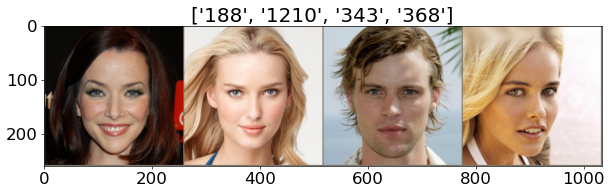

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [18]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### <b>Training Phase</b>


In [19]:
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 1.9991 Acc: 30.9859% Time: 18.0307s
[Test #0] Loss: 2.0335 Acc: 42.0000% Time: 19.7244s
[Train #1] Loss: 0.6826 Acc: 79.8122% Time: 39.9616s
[Test #1] Loss: 1.3157 Acc: 56.0000% Time: 42.0456s
[Train #2] Loss: 0.1752 Acc: 95.7747% Time: 62.9362s
[Test #2] Loss: 0.5394 Acc: 80.0000% Time: 65.3843s
[Train #3] Loss: 0.1112 Acc: 96.2441% Time: 84.2797s
[Test #3] Loss: 0.5313 Acc: 82.0000% Time: 86.3014s
[Train #4] Loss: 0.2374 Acc: 91.5493% Time: 103.4949s
[Test #4] Loss: 2.0264 Acc: 50.0000% Time: 105.2703s
[Train #5] Loss: 0.3398 Acc: 90.1408% Time: 124.2072s
[Test #5] Loss: 3.0831 Acc: 46.0000% Time: 125.9968s
[Train #6] Loss: 0.1734 Acc: 96.2441% Time: 144.1953s
[Test #6] Loss: 1.0509 Acc: 80.0000% Time: 146.6006s
[Train #7] Loss: 0.3491 Acc: 90.6103% Time: 165.8253s
[Test #7] Loss: 0.8205 Acc: 80.0000% Time: 167.9389s
[Train #8] Loss: 0.3721 Acc: 88.2629% Time: 186.8357s
[Test #8] Loss: 1.5802 Acc: 60.0000% Time: 188.8973s
[Train #9] Loss: 0.2941 Acc: 92.9577% Time: 2

### <b>Final Test Phase</b>

* Save the trained model file.

In [20]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [21]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* Evaluate the trained model.

[Original Image Examples]


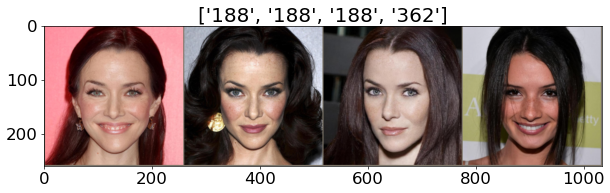

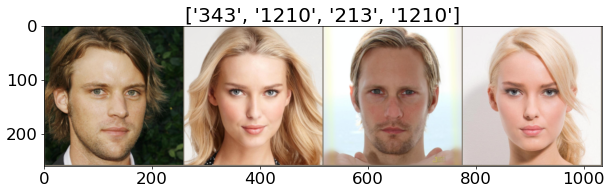

[Prediction Result Examples]


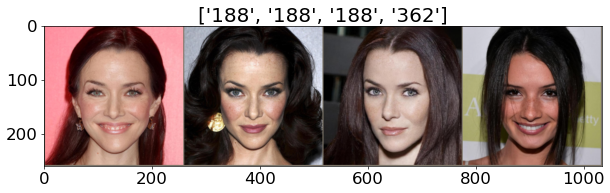

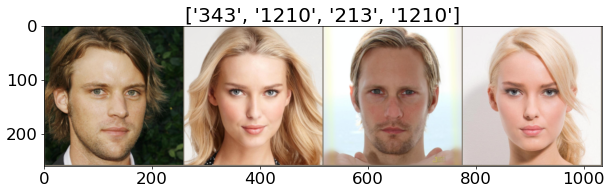

[Test #29] Loss: 0.6250 Acc: 84.0000% Time: 2.6856s


In [22]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

Predicted class: 213
[Original Image Examples]


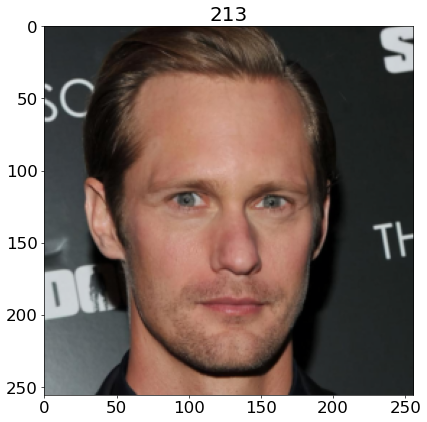

In [31]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

#pick appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
#create image translations according to Resnet global values
#Training has a random flip to help teach the classifier
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Load up the our dataset
data_dir = './reduced_celebA'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
class_names = train_dataset.classes

#fetch the resnet model, change it to fit our number of classifications, and then load the weights we saved from training the model
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # fetch the resnet model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # multi-class classification (num_of_class == 10) change it to fit our number of classifications
model.load_state_dict(torch.load(save_path)) # load the weights we saved from training the model
model.to(device)


#Load image and transform it so ResNet Can recognize it
image = Image.open("poisoned_213.jpg")
image_tensor = transforms_test(image)

#Load the model
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))

_, predicted = torch.max(output.data, 1)
predicted_class = class_names[predicted]
print("Predicted class:", predicted_class)

print('[Original Image Examples]')
#images = torchvision.utils.make_grid(inputs[:1])
imshow(image_tensor, title=predicted_class)